# Modelos: KNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import util as ut

import random

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

In [8]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

<torch._C.Generator object at 0x7fcf69949610>

In [9]:
WEIGHTS_PATH = '../weights'

In [10]:
TRAIN = False

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-25 13:22:21,779 - INFO - Train: 83.74 % - Test: 7.71 %


## Entrenamiento del modelo

In [13]:
if TRAIN:
    user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [14]:
if TRAIN:
    user_predictor.plot()

In [15]:
if TRAIN:
    item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [16]:
if TRAIN:
    item_predictor.plot()

Se guardan los modelo entrenado:

In [17]:
if TRAIN:
    user_predictor.save(WEIGHTS_PATH,'knn-user-predictor ')
    item_predictor.save(WEIGHTS_PATH,'knn-item-predictor')

In [18]:
if TRAIN:
    user_predictor.delete()
    item_predictor.delete()

## Validación del modelo

In [13]:
ut.free_gpu_memory()

In [14]:
user_predictor = ml.KNNUserBasedPredictor.from_file(WEIGHTS_PATH, 'knn-user-predictor')

In [15]:
item_predictor = ml.KNNItemBasedPredictor.from_file(WEIGHTS_PATH,'knn-item-predictor')

Decoramos los predictores un con cache para disminuir los tiempo de predicción, ya que no tiene sentido realizar dos veces la misma predicción para estos modelos donde el resultado no es aleatorio:

In [16]:
cached_user_predictor = ml.CachedPredictor(user_predictor)
cached_item_predictor = ml.CachedPredictor(item_predictor)

Armamos un ensample para validar si mejora la performance de ambos modelos:

In [17]:
ensemple_predictor = ml.EnsemplePredictor([cached_user_predictor, cached_item_predictor])

In [18]:
def validation(
    predictors, 
    n_samples    = 100, 
    batch_size   = 1000, 
    n_neighbors  = 100,
    k            = [5, 5],
    user_index   = 0,
    discretizers = [dr.between(4, 5), dr.between(3, 5)],
    summary_path = '../metrics/knn'
):
    metrics    = [mt.RMSE()]

    for k, discretizer in zip(k, discretizers):
        metrics.extend([
            mt.MeanAveragePrecisionAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserFBetaScoreAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserPrecisionAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserRecallAtk(user_index=user_index, k=k, discretizer=discretizer)
        ])

    validator = ml.Validator(
        n_samples,
        batch_size,
        metrics,
        predictors
    )

    summary = validator.validate(eval_set, n_neighbors=n_neighbors)

    summary.save(summary_path)
    summary = ml.ValidatorSummary.load(summary_path)
    summary.plot(bins=12, show_table=True)


Processing:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

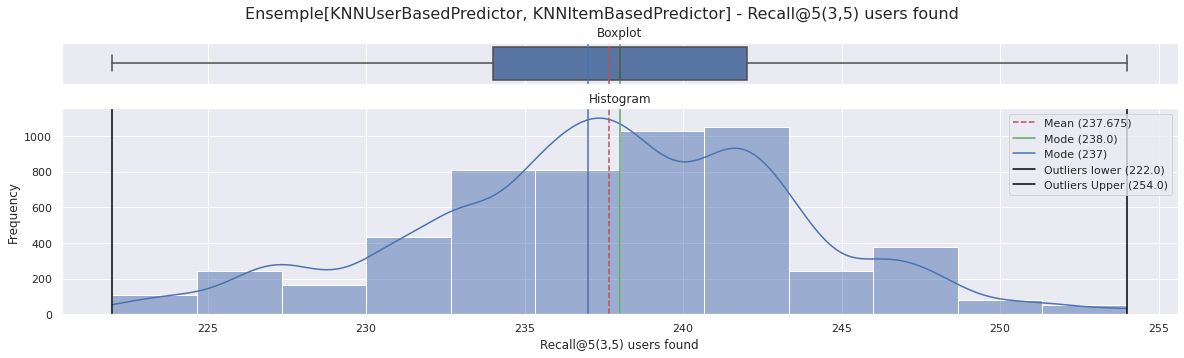


Metrics:



,"Recall@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

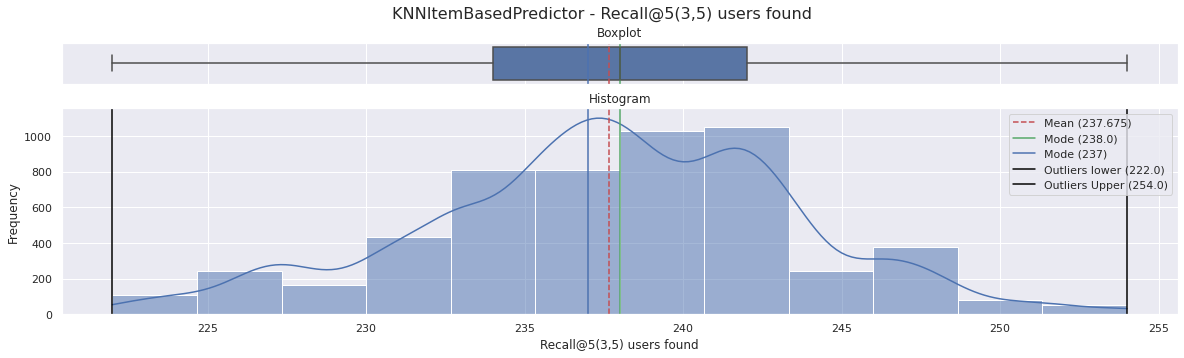


Metrics:



,"Recall@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

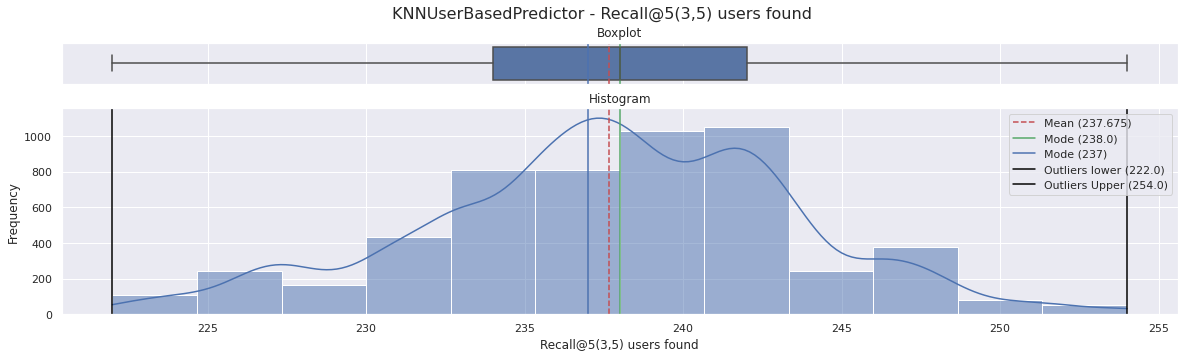


Metrics:



,"Recall@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

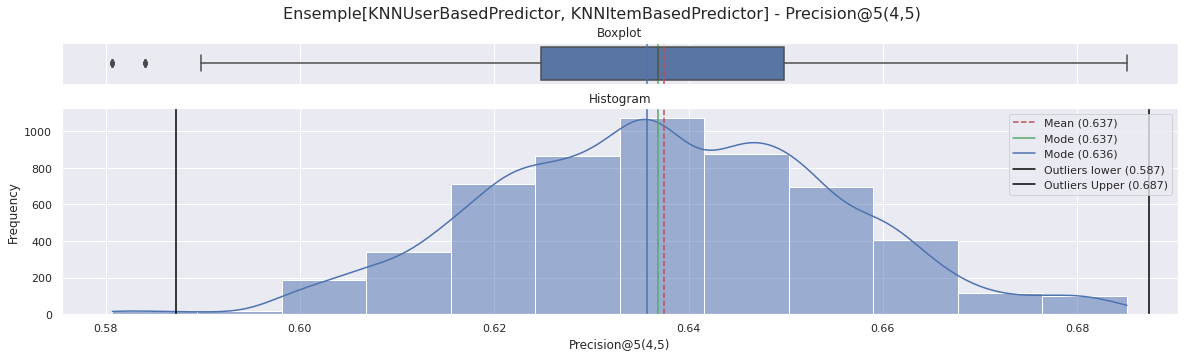


Metrics:



,"Precision@5(4,5)"
count,5400.000000
mean,0.637438
std,0.017686
min,0.580702
25%,0.624792
50%,0.636842
75%,0.649849
max,0.685124


<Figure size 1440x360 with 2 Axes>

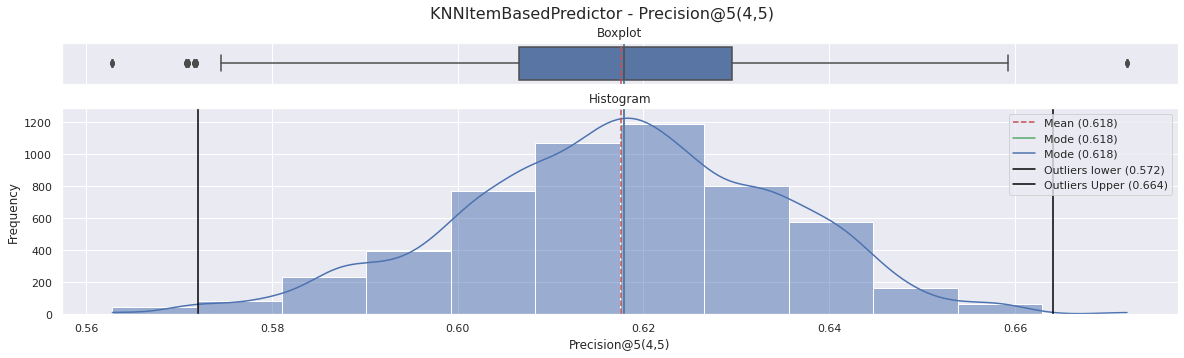


Metrics:



,"Precision@5(4,5)"
count,5400.000000
mean,0.617542
std,0.017054
min,0.562810
25%,0.606558
50%,0.617872
75%,0.629559
max,0.672065


<Figure size 1440x360 with 2 Axes>

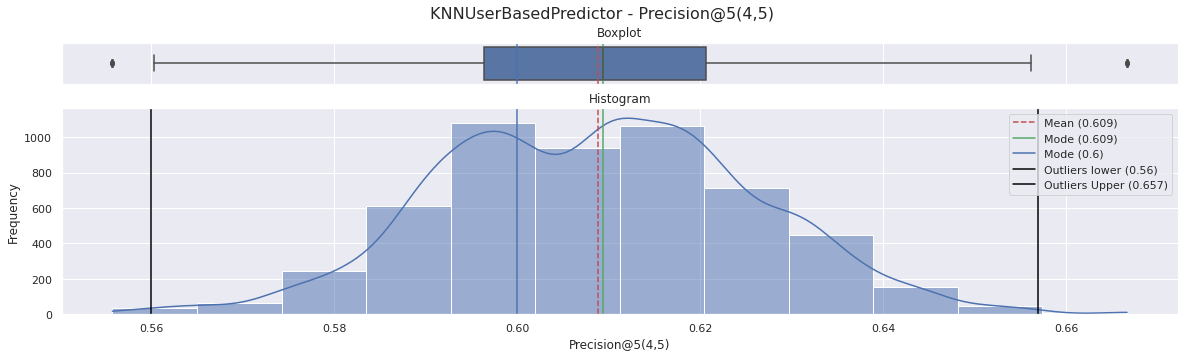


Metrics:



,"Precision@5(4,5)"
count,5400.000000
mean,0.608780
std,0.017212
min,0.555745
25%,0.596345
50%,0.609402
75%,0.620597
max,0.666667


<Figure size 1440x360 with 2 Axes>

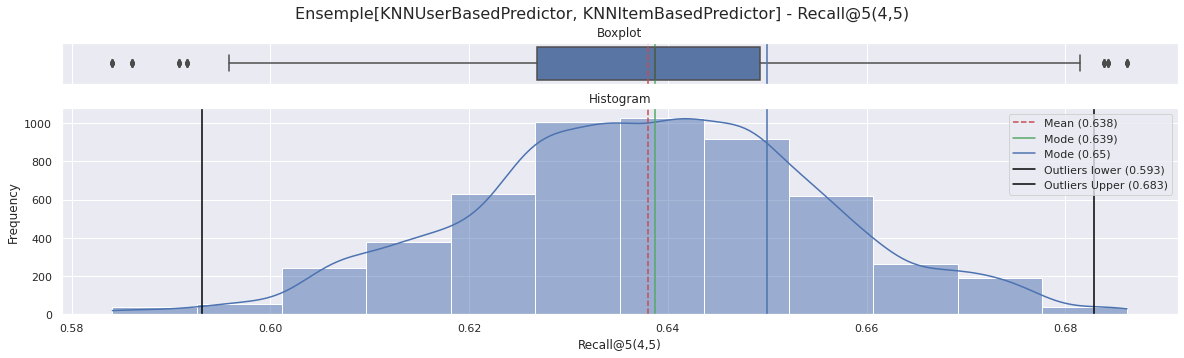


Metrics:



,"Recall@5(4,5)"
count,5400.000000
mean,0.637978
std,0.017436
min,0.584100
25%,0.626784
50%,0.638696
75%,0.649230
max,0.686192


<Figure size 1440x360 with 2 Axes>

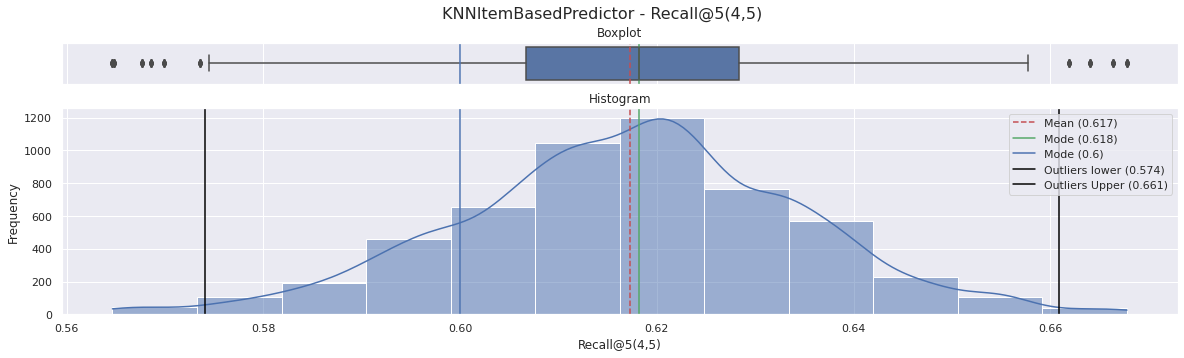


Metrics:



,"Recall@5(4,5)"
count,5400.000000
mean,0.617251
std,0.017272
min,0.564655
25%,0.606647
50%,0.618182
75%,0.628358
max,0.667782


<Figure size 1440x360 with 2 Axes>

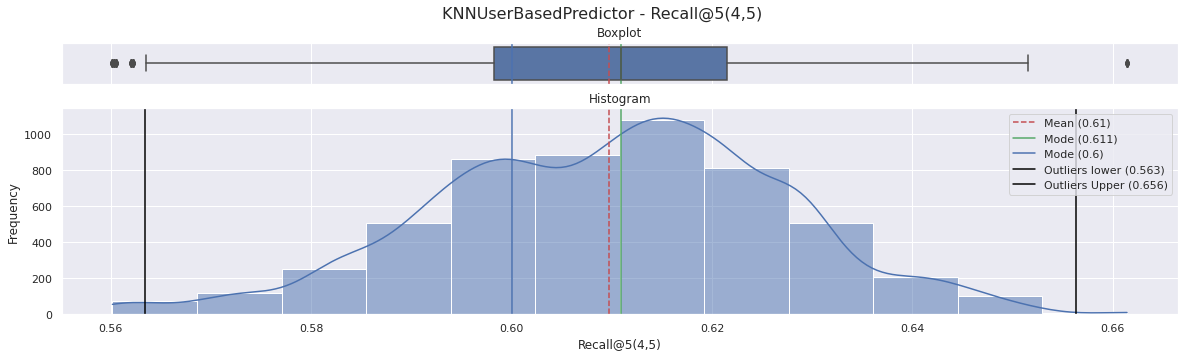


Metrics:



,"Recall@5(4,5)"
count,5400.000000
mean,0.609726
std,0.017309
min,0.560163
25%,0.598261
50%,0.610902
75%,0.621488
max,0.661404


<Figure size 1440x360 with 2 Axes>

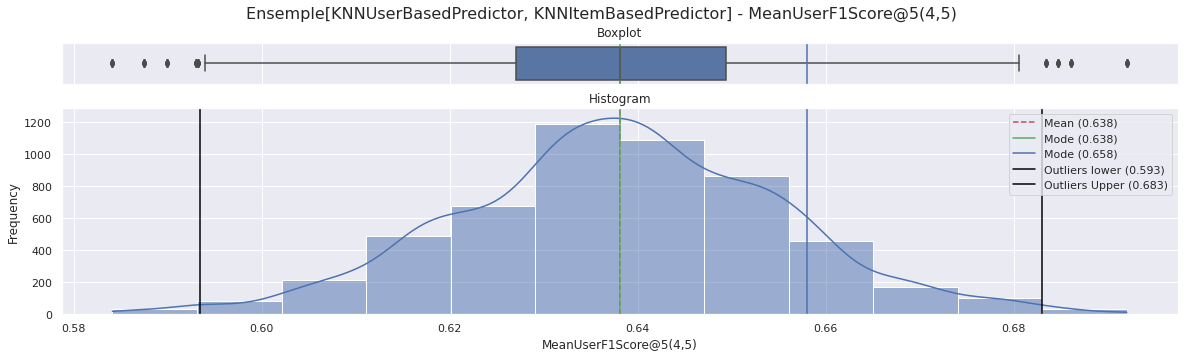


Metrics:



,"MeanUserF1Score@5(4,5)"
count,5400.000000
mean,0.638093
std,0.017306
min,0.584100
25%,0.627004
50%,0.638155
75%,0.649411
max,0.692050


<Figure size 1440x360 with 2 Axes>

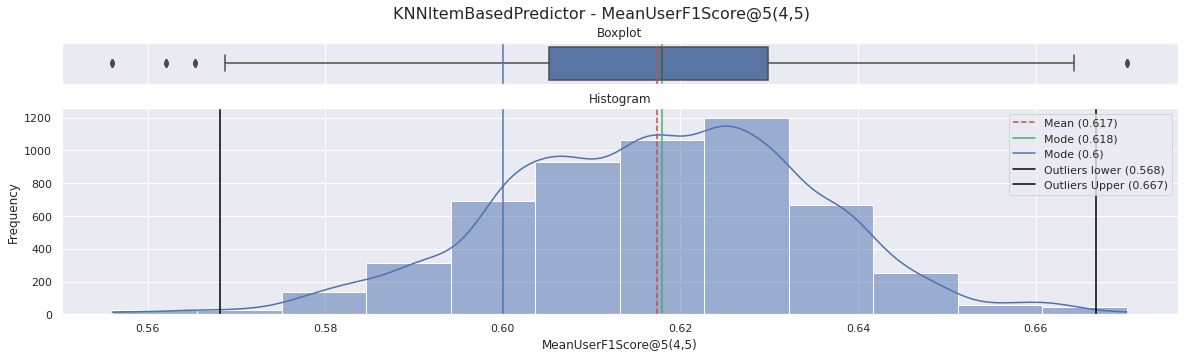


Metrics:



,"MeanUserF1Score@5(4,5)"
count,5400.000000
mean,0.617377
std,0.017522
min,0.556035
25%,0.605167
50%,0.617915
75%,0.629809
max,0.670293


<Figure size 1440x360 with 2 Axes>

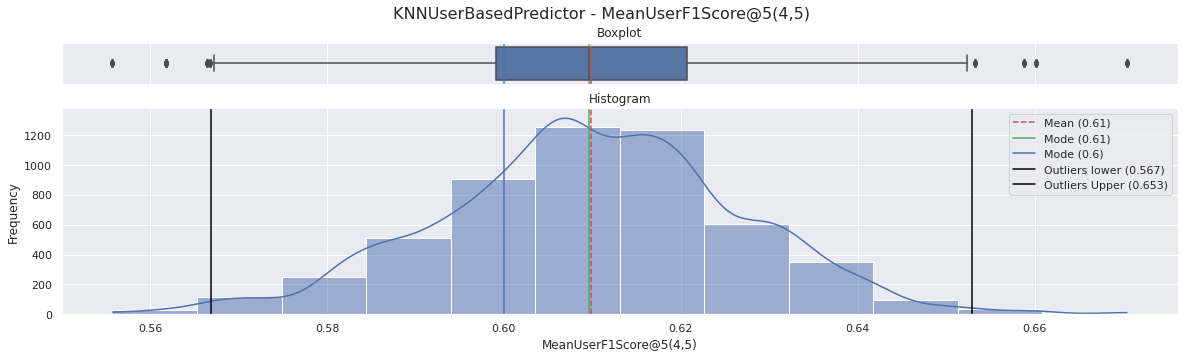


Metrics:



,"MeanUserF1Score@5(4,5)"
count,5400.000000
mean,0.609814
std,0.017025
min,0.555738
25%,0.599156
50%,0.609620
75%,0.620683
max,0.670445


<Figure size 1440x360 with 2 Axes>

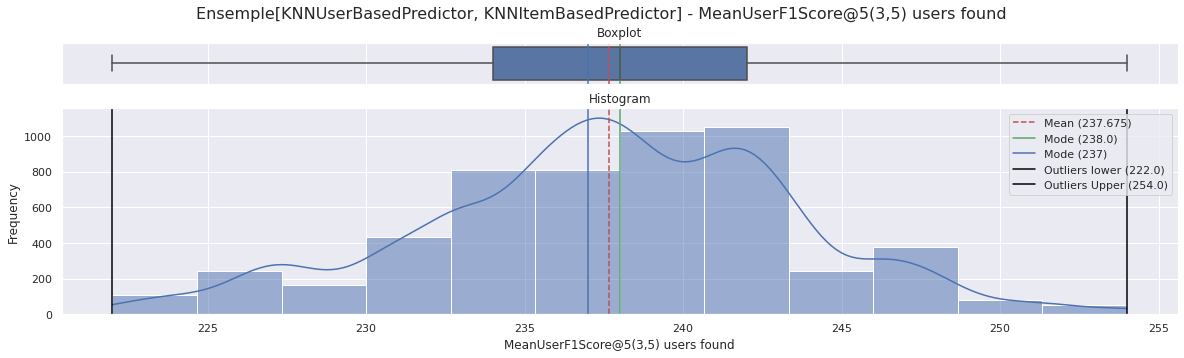


Metrics:



,"MeanUserF1Score@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

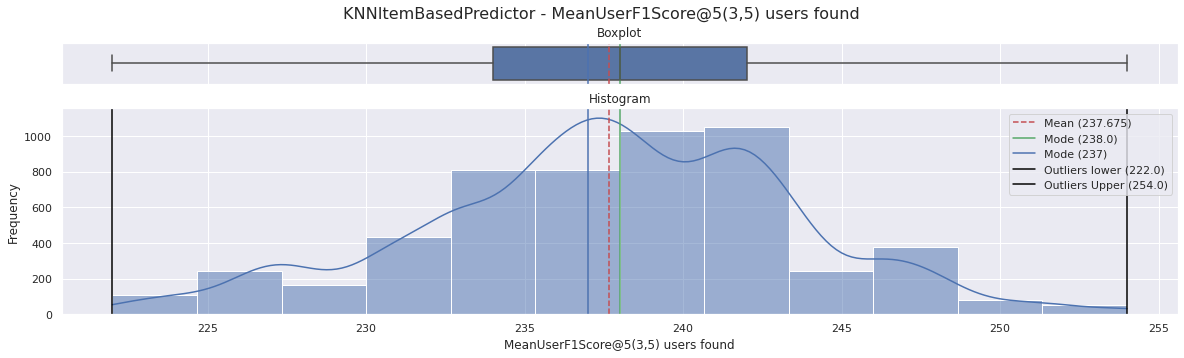


Metrics:



,"MeanUserF1Score@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

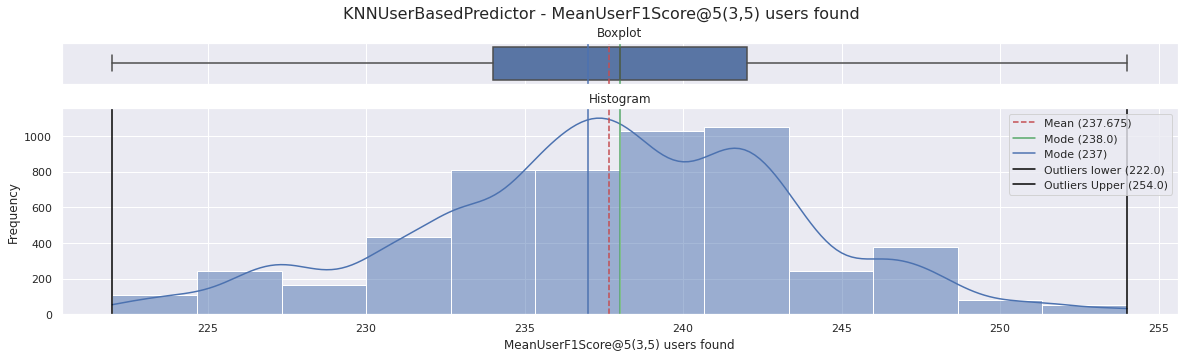


Metrics:



,"MeanUserF1Score@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

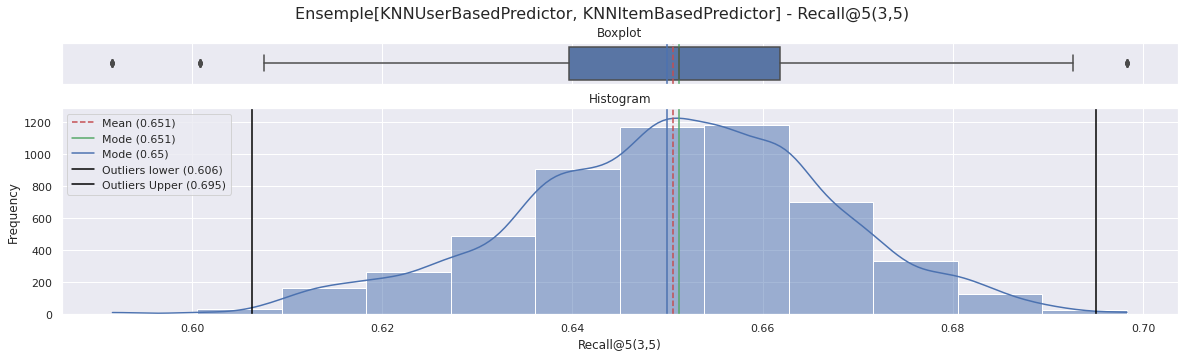


Metrics:



,"Recall@5(3,5)"
count,5400.000000
mean,0.650548
std,0.016474
min,0.591632
25%,0.639623
50%,0.651260
75%,0.661818
max,0.698319


<Figure size 1440x360 with 2 Axes>

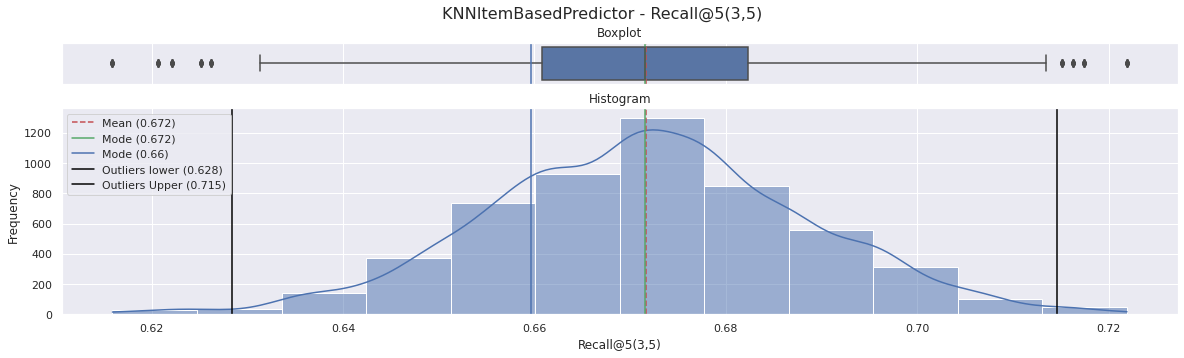


Metrics:



,"Recall@5(3,5)"
count,5400.000000
mean,0.671687
std,0.016754
min,0.615900
25%,0.660748
50%,0.671609
75%,0.682294
max,0.721930


<Figure size 1440x360 with 2 Axes>

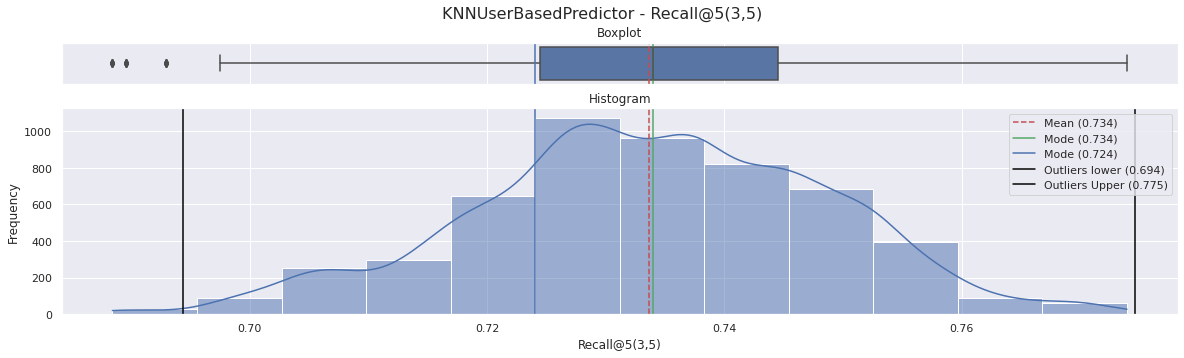


Metrics:



,"Recall@5(3,5)"
count,5400.000000
mean,0.733665
std,0.014906
min,0.688412
25%,0.724464
50%,0.734019
75%,0.744538
max,0.773950


<Figure size 1440x360 with 2 Axes>

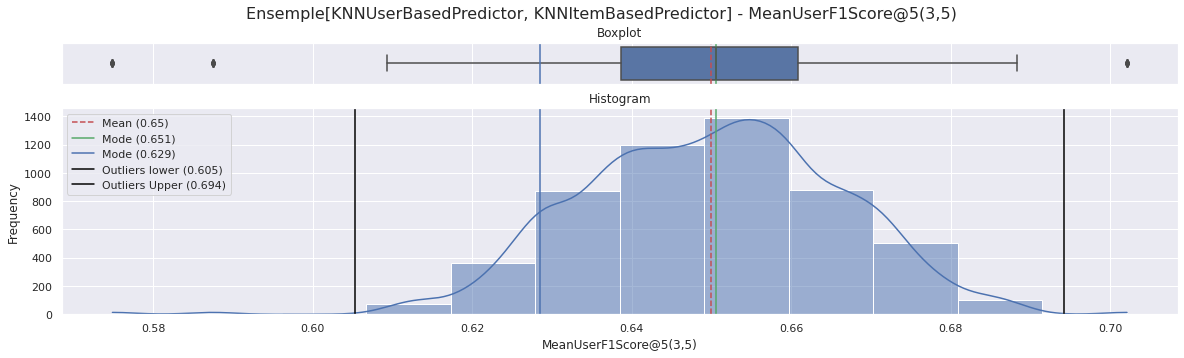


Metrics:



,"MeanUserF1Score@5(3,5)"
count,5400.000000
mean,0.649969
std,0.016185
min,0.574895
25%,0.638656
50%,0.650530
75%,0.660888
max,0.702128


<Figure size 1440x360 with 2 Axes>

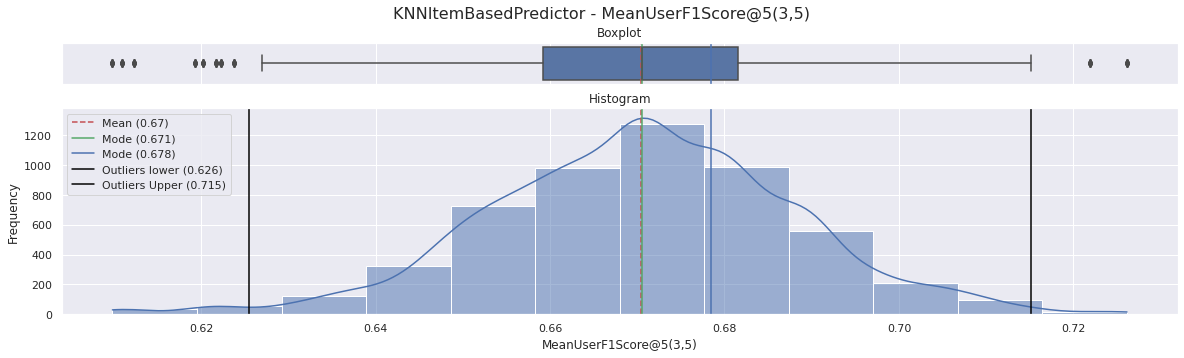


Metrics:



,"MeanUserF1Score@5(3,5)"
count,5400.000000
mean,0.670432
std,0.017595
min,0.609836
25%,0.659143
50%,0.670564
75%,0.681545
max,0.726141


<Figure size 1440x360 with 2 Axes>

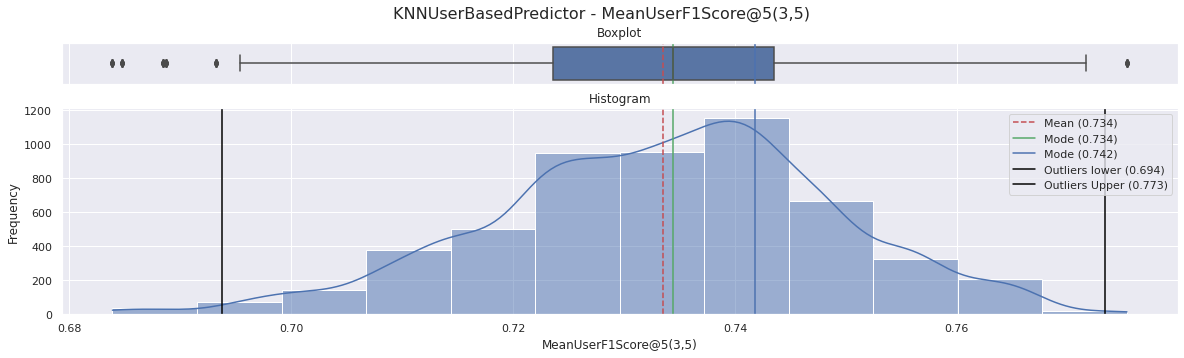


Metrics:



,"MeanUserF1Score@5(3,5)"
count,5400.000000
mean,0.733553
std,0.015390
min,0.683898
25%,0.723605
50%,0.734454
75%,0.743487
max,0.775330


<Figure size 1440x360 with 2 Axes>

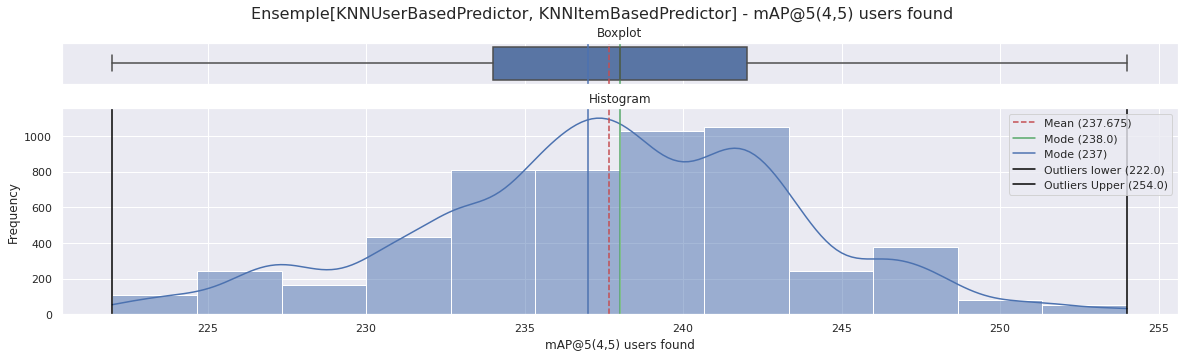


Metrics:



,"mAP@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

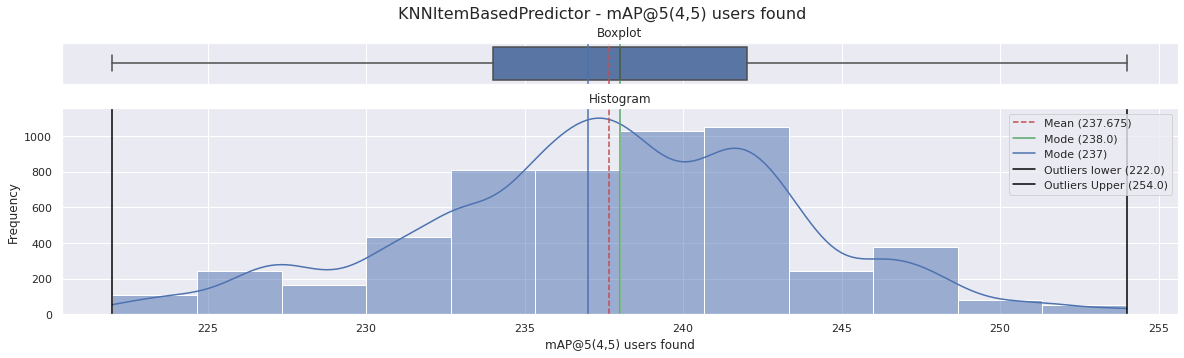


Metrics:



,"mAP@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

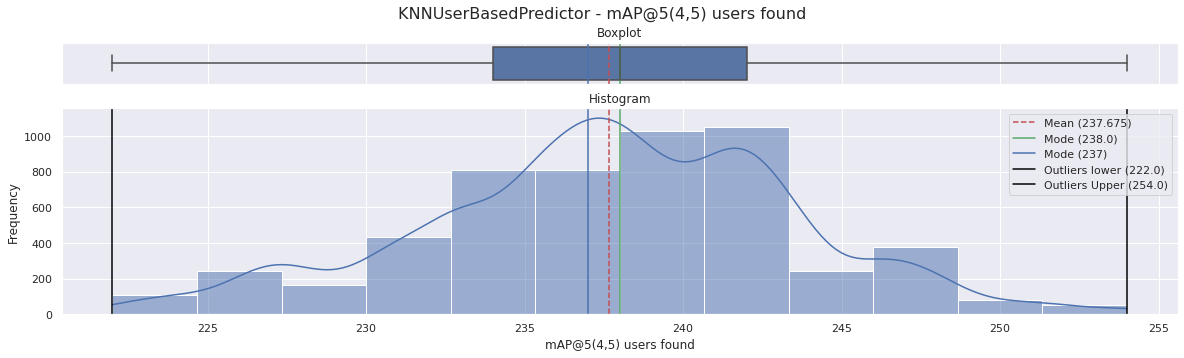


Metrics:



,"mAP@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

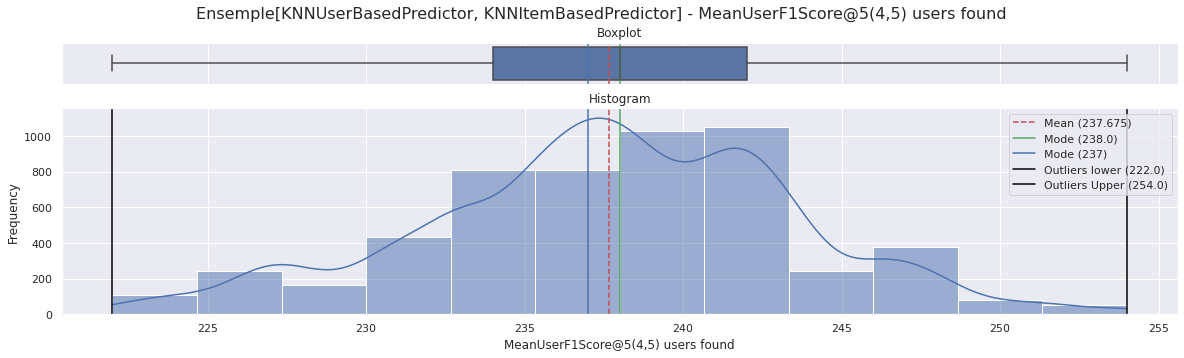


Metrics:



,"MeanUserF1Score@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

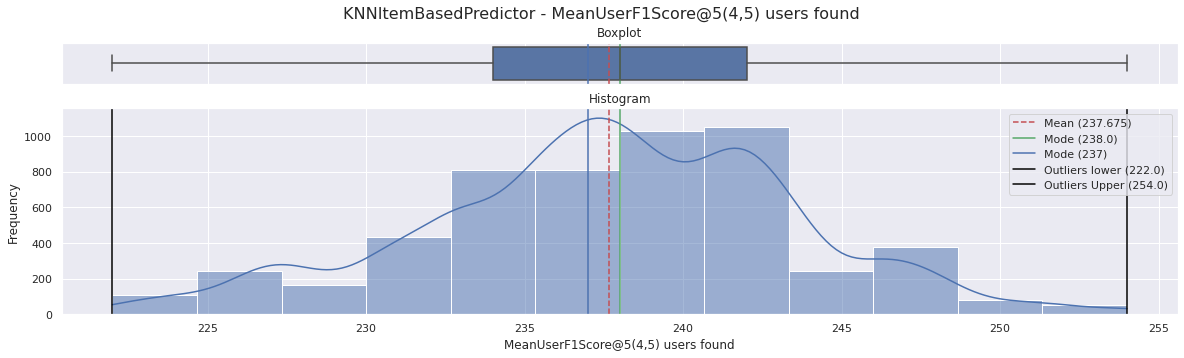


Metrics:



,"MeanUserF1Score@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

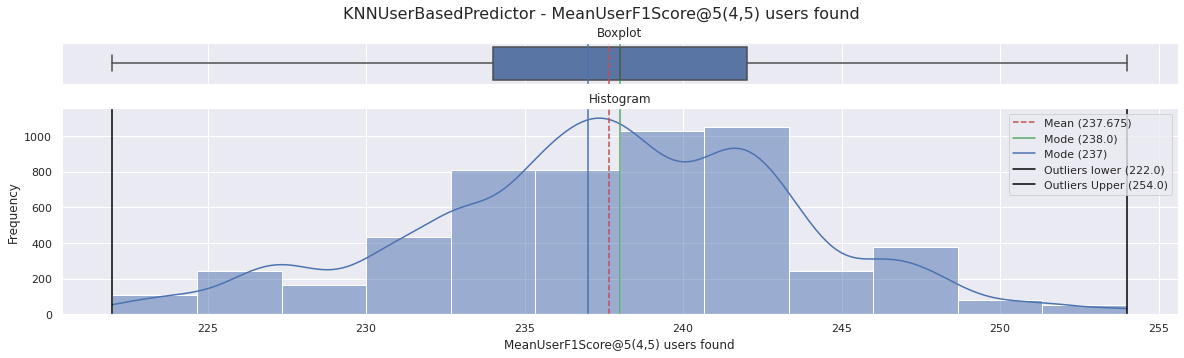


Metrics:



,"MeanUserF1Score@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

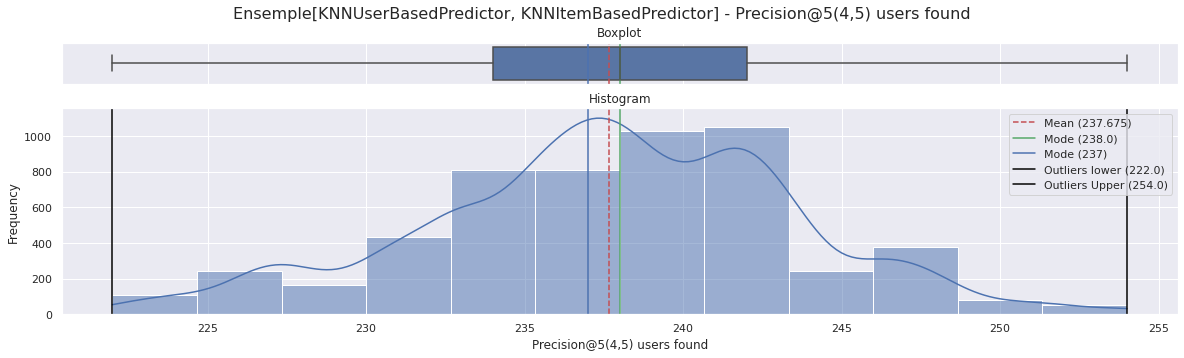


Metrics:



,"Precision@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

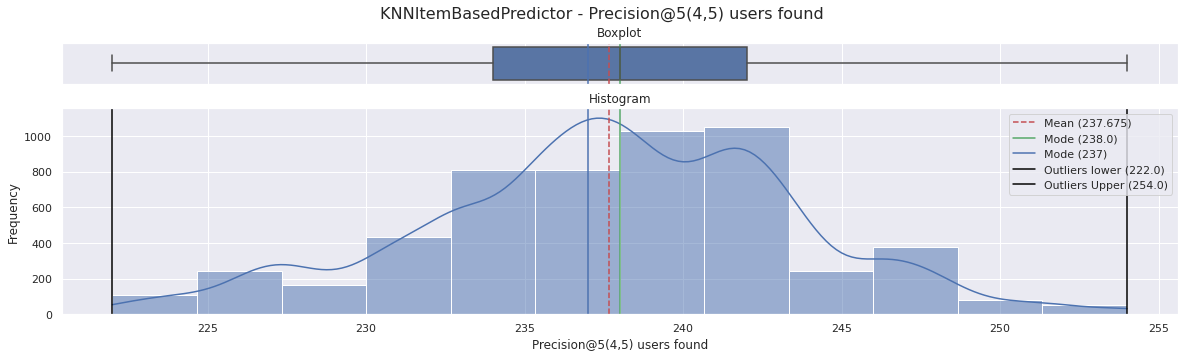


Metrics:



,"Precision@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

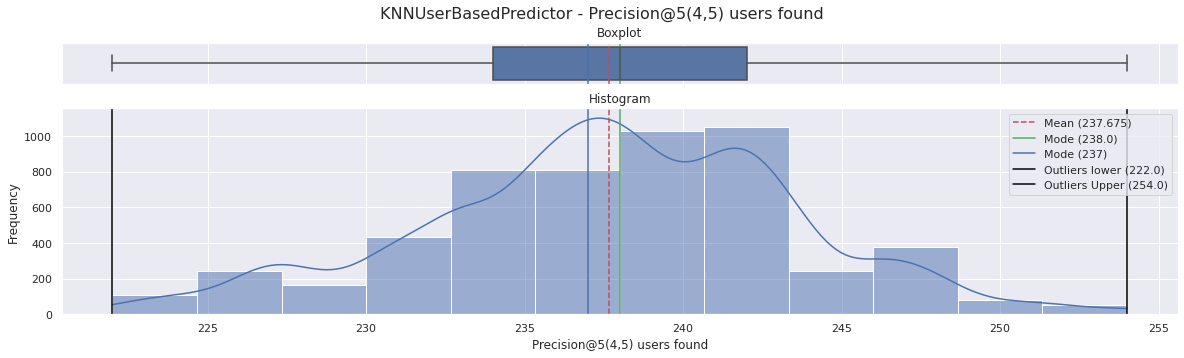


Metrics:



,"Precision@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

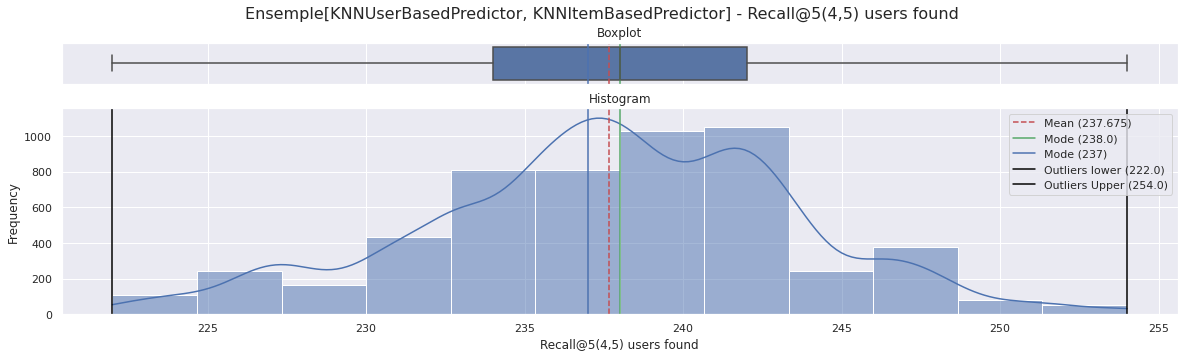


Metrics:



,"Recall@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

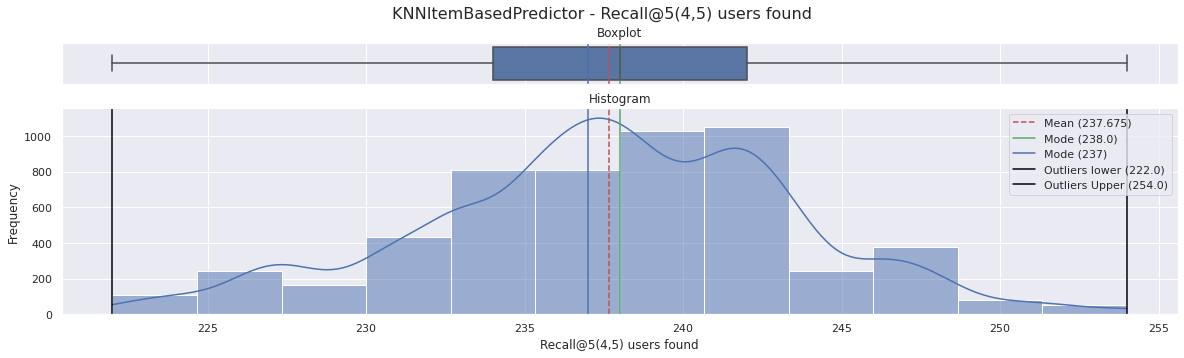


Metrics:



,"Recall@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

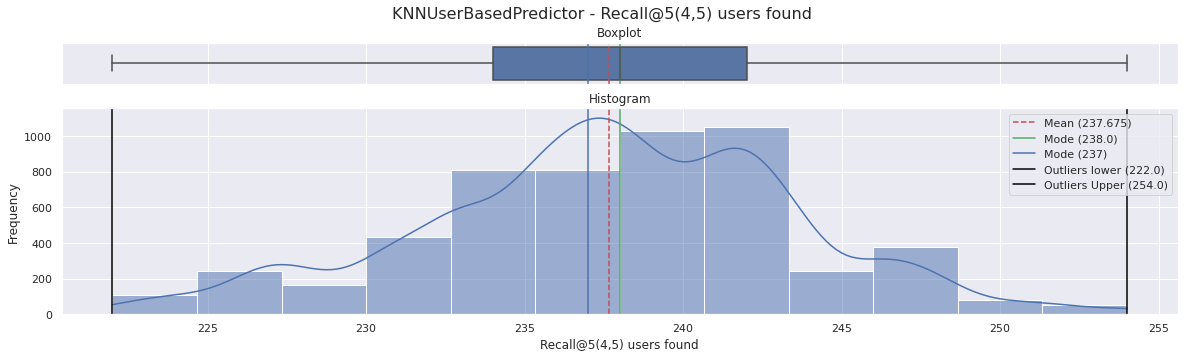


Metrics:



,"Recall@5(4,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

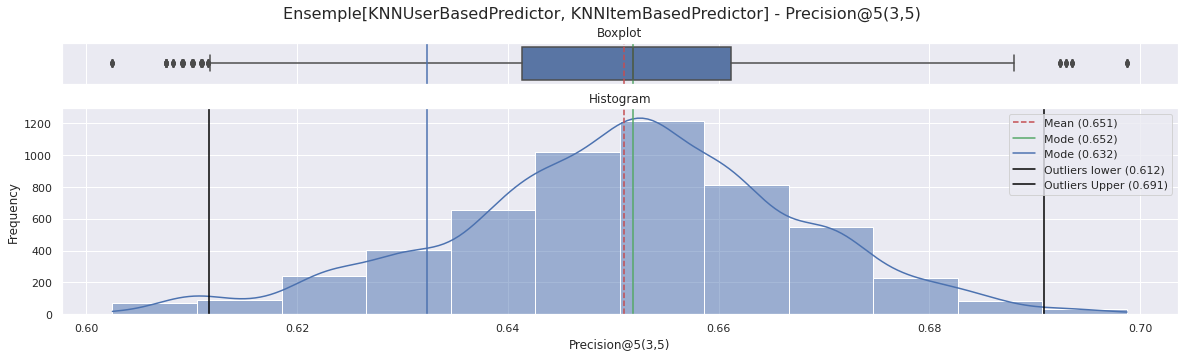


Metrics:



,"Precision@5(3,5)"
count,5400.000000
mean,0.651039
std,0.016233
min,0.602479
25%,0.641343
50%,0.651899
75%,0.661169
max,0.698745


<Figure size 1440x360 with 2 Axes>

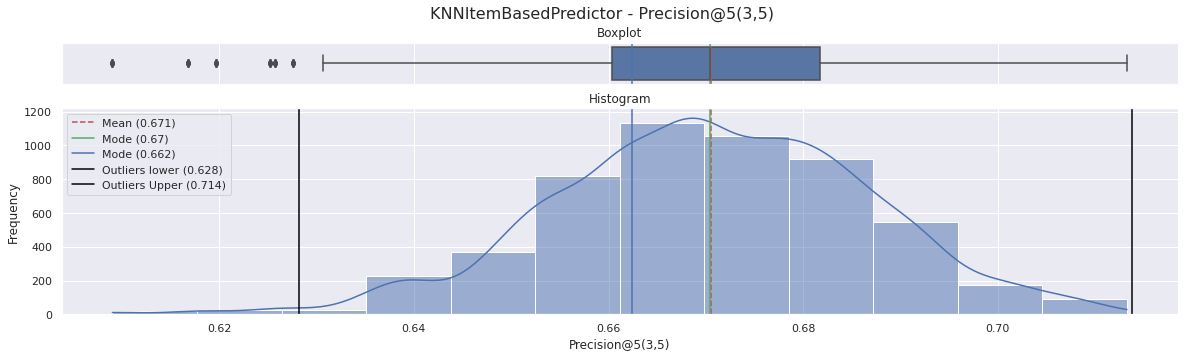


Metrics:



,"Precision@5(3,5)"
count,5400.000000
mean,0.670516
std,0.016184
min,0.609016
25%,0.660311
50%,0.670416
75%,0.681705
max,0.713274


<Figure size 1440x360 with 2 Axes>

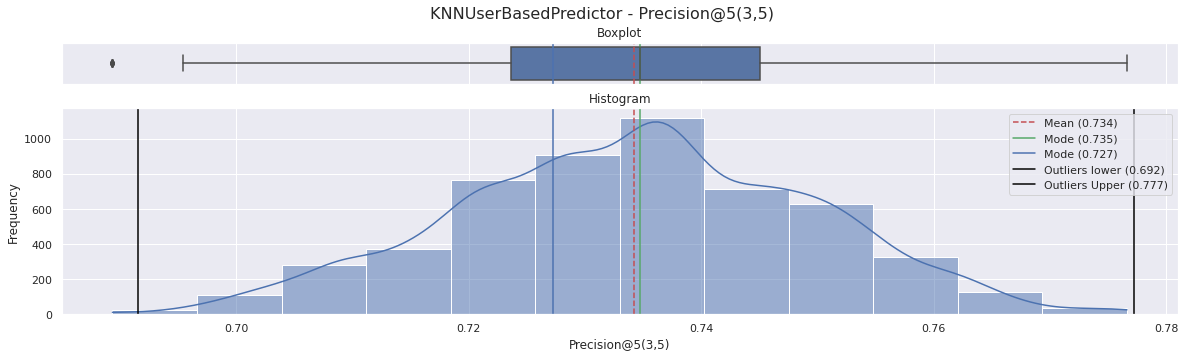


Metrics:



,"Precision@5(3,5)"
count,5400.000000
mean,0.734211
std,0.015269
min,0.689362
25%,0.723664
50%,0.734728
75%,0.745082
max,0.776623


<Figure size 1440x360 with 2 Axes>

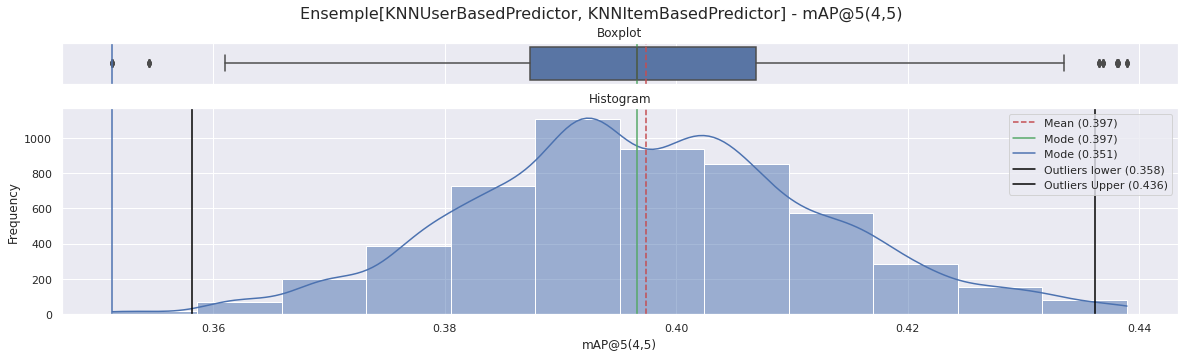


Metrics:



,"mAP@5(4,5)"
count,5400.000000
mean,0.397417
std,0.015096
min,0.351291
25%,0.387385
50%,0.396616
75%,0.406884
max,0.438933


<Figure size 1440x360 with 2 Axes>

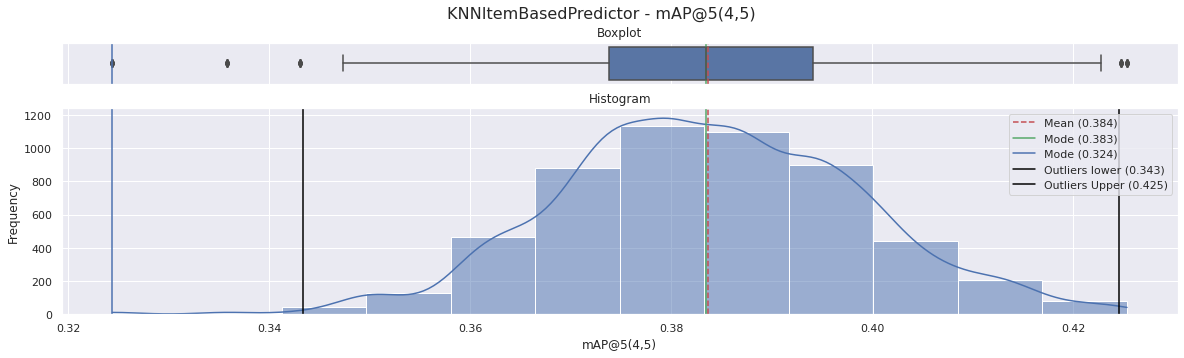


Metrics:



,"mAP@5(4,5)"
count,5400.000000
mean,0.383683
std,0.015055
min,0.324373
25%,0.373788
50%,0.383420
75%,0.394074
max,0.425329


<Figure size 1440x360 with 2 Axes>

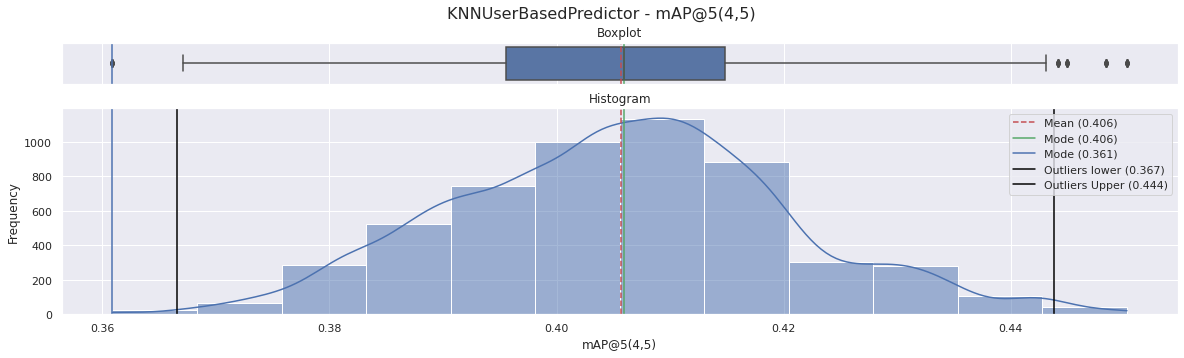


Metrics:



,"mAP@5(4,5)"
count,5400.000000
mean,0.405644
std,0.014878
min,0.360903
25%,0.395543
50%,0.405977
75%,0.414858
max,0.450218


<Figure size 1440x360 with 2 Axes>

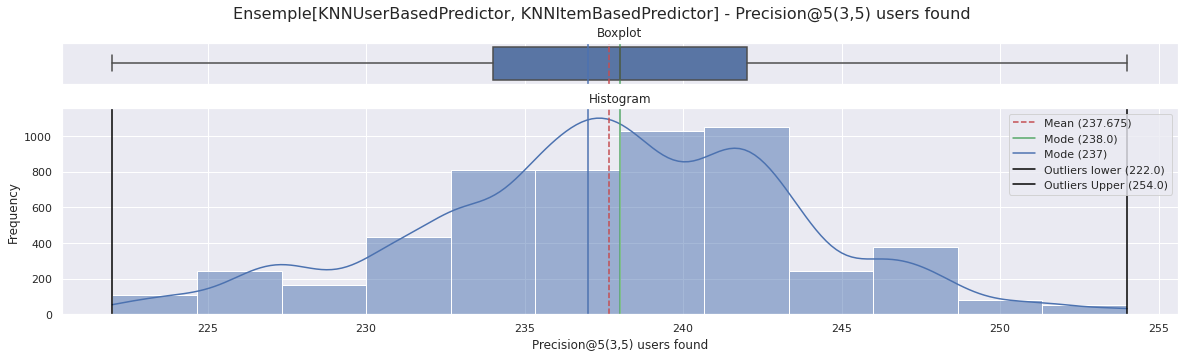


Metrics:



,"Precision@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

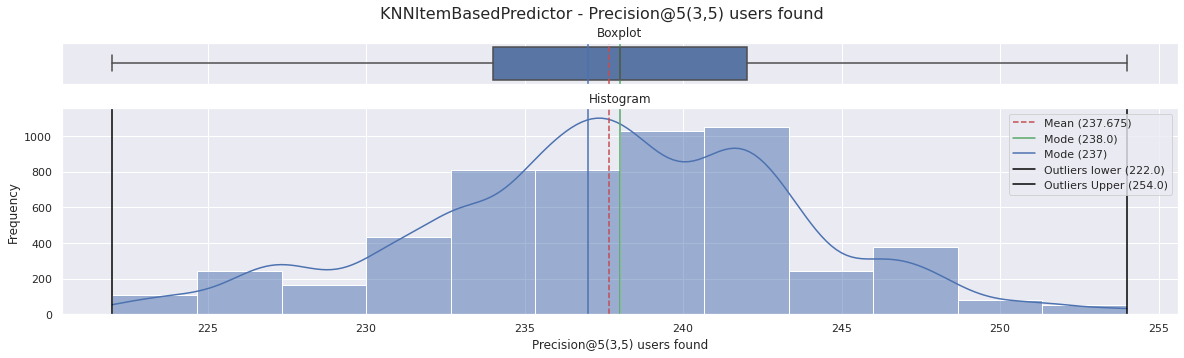


Metrics:



,"Precision@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

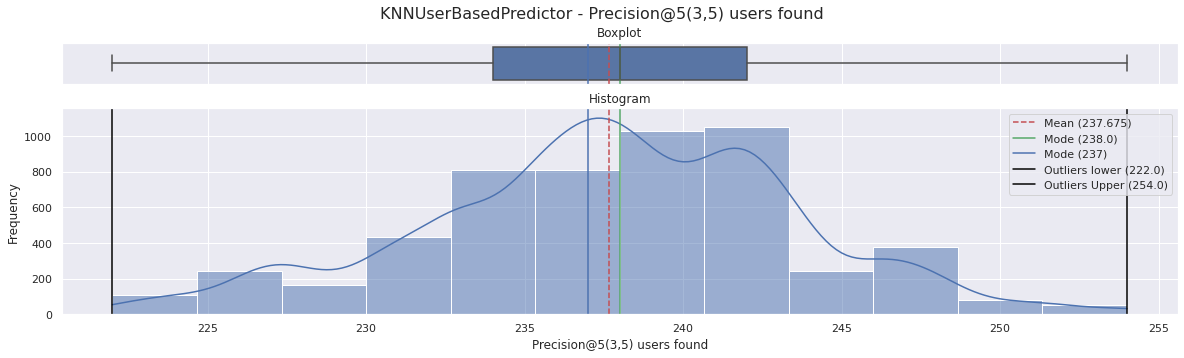


Metrics:



,"Precision@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

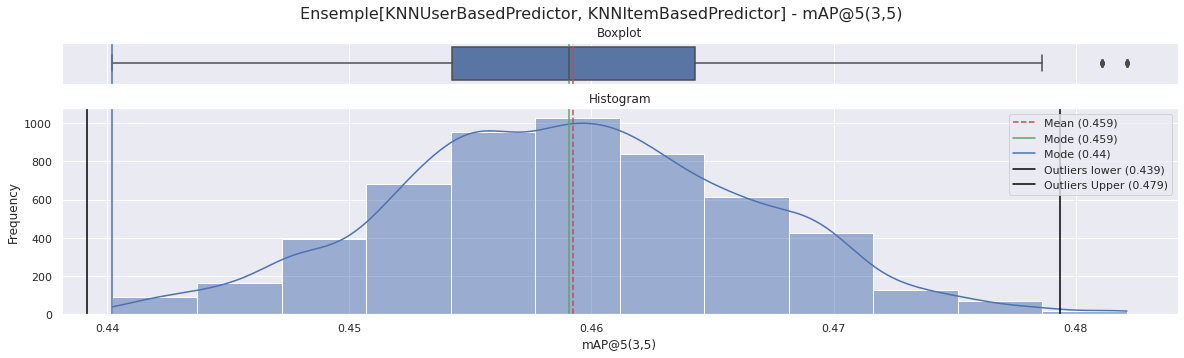


Metrics:



,"mAP@5(3,5)"
count,5400.000000
mean,0.459241
std,0.007302
min,0.440209
25%,0.454236
50%,0.459086
75%,0.464289
max,0.482125


<Figure size 1440x360 with 2 Axes>

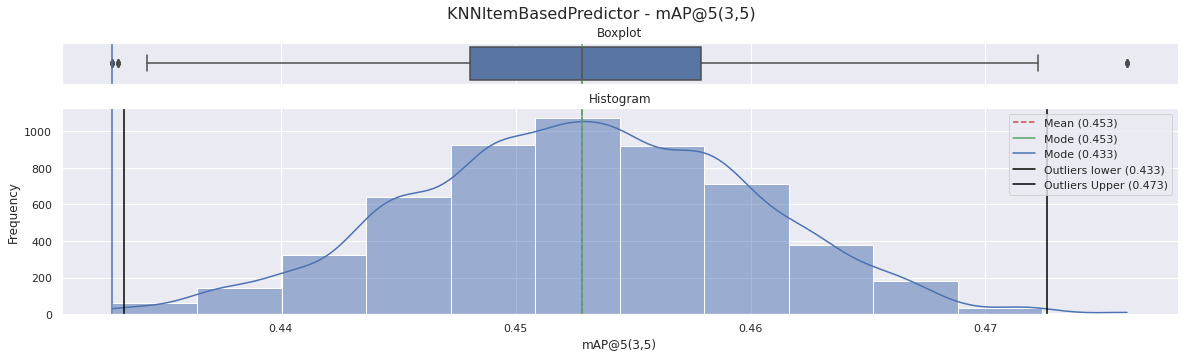


Metrics:



,"mAP@5(3,5)"
count,5400.000000
mean,0.452825
std,0.007192
min,0.432837
25%,0.448074
50%,0.452826
75%,0.457894
max,0.476026


<Figure size 1440x360 with 2 Axes>

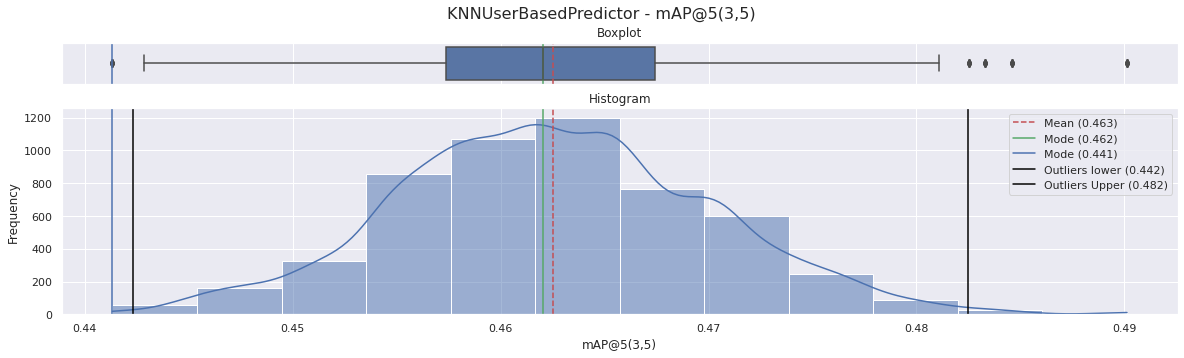


Metrics:



,"mAP@5(3,5)"
count,5400.000000
mean,0.462532
std,0.007530
min,0.441333
25%,0.457381
50%,0.462059
75%,0.467419
max,0.490122


<Figure size 1440x360 with 2 Axes>

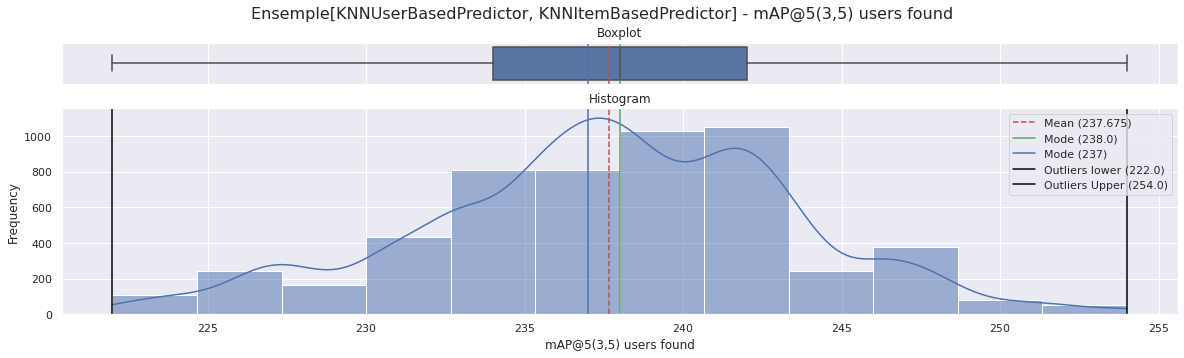


Metrics:



,"mAP@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

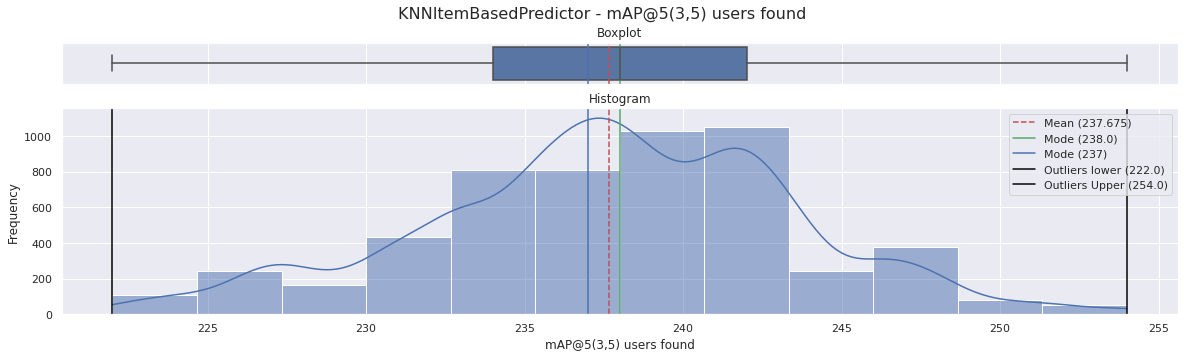


Metrics:



,"mAP@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

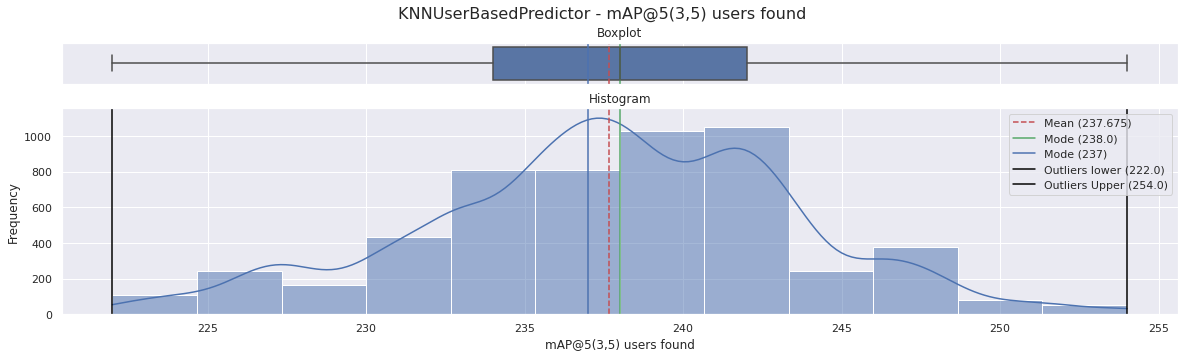


Metrics:



,"mAP@5(3,5) users found"
count,5400.000000
mean,237.675000
std,5.903035
min,222.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,254.000000


<Figure size 1440x360 with 2 Axes>

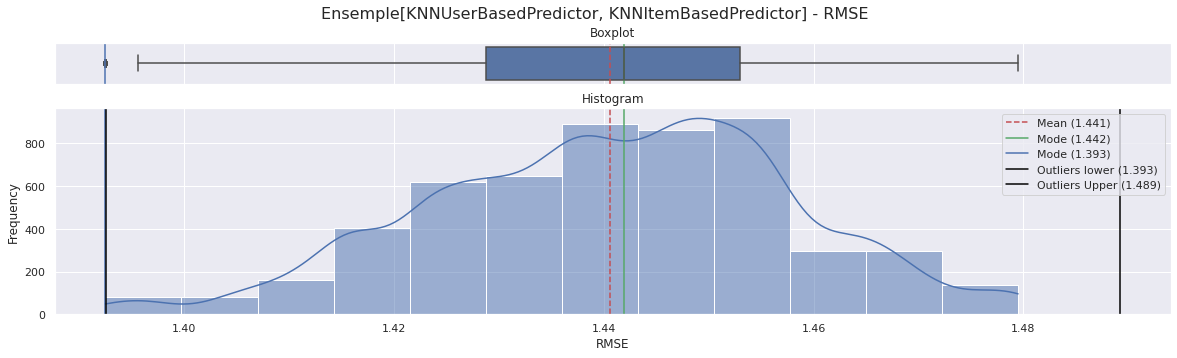


Metrics:



,RMSE
count,5400.000000
mean,1.440606
std,0.017145
min,1.392502
25%,1.428785
50%,1.441900
75%,1.452955
max,1.479497


<Figure size 1440x360 with 2 Axes>

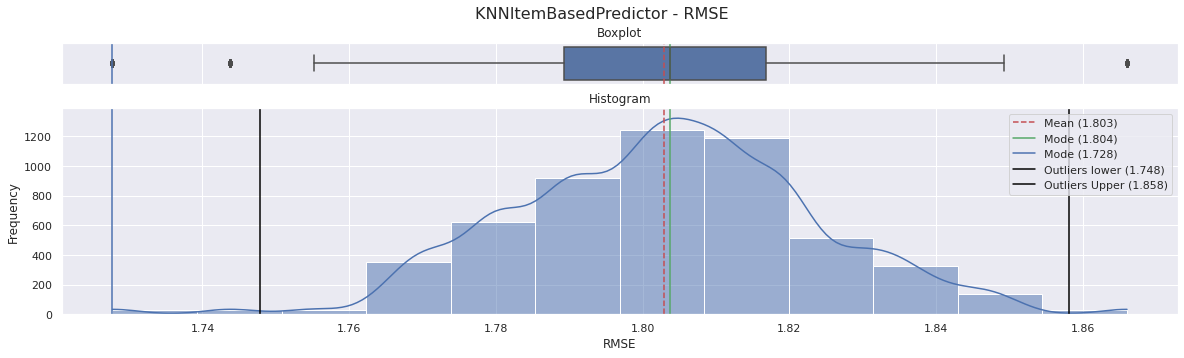


Metrics:



,RMSE
count,5400.000000
mean,1.802944
std,0.020754
min,1.727724
25%,1.789218
50%,1.803689
75%,1.816786
max,1.866017


<Figure size 1440x360 with 2 Axes>

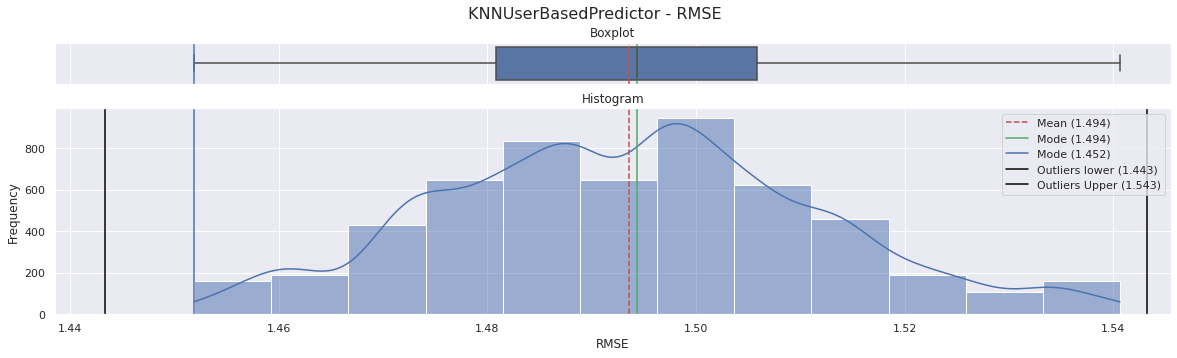


Metrics:



,RMSE
count,5400.000000
mean,1.493595
std,0.018100
min,1.451892
25%,1.480835
50%,1.494367
75%,1.505795
max,1.540625


In [21]:
validation(
    [cached_user_predictor, cached_item_predictor, ensemple_predictor],
    n_samples    = 200,
    batch_size   = 5000,
    n_neighbors  = 5000,
    summary_path = '../metrics/knn'
)